<a href="https://colab.research.google.com/github/SukhpreetKhangura/Task/blob/master/Task_1_CNN_Denoising_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check the tensorflow version to avoid using any deprecated functions

In [0]:
import tensorflow as tf   
print(tf.__version__) # Print the version of the tensor flow

2.2.0


Import all neceassry libraries

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,  Dropout, MaxPooling2D, UpSampling2D,BatchNormalization,Activation
from tensorflow.keras.utils import  plot_model

import os 
import random
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

seed_value=np.random.seed(5) #to keep all the random function calls consistent



## Obtain the Dataset:

1. To obtain the dataset we mount the google drive into colab
2. Create the Task directory in tmp if it doesnot exists
3. Copy the contents from the source directory(google drive) to the destination
4. Extract the contents from zipped random image folder

In [0]:
# Step 1
from google.colab import drive # Mount the Google Drive
drive.mount('/content/drive',force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Step 2

if not os.path.exists('/tmp/Task_Cinemo'):
     os.mkdir('/tmp/Task_Cinemo')    # Making directory of Task in tmp

In [0]:
# Step 3
!cp "/content/drive/My Drive/Task_Cinemo/src_images.zip" "/tmp/Task_Cinemo/src_images.zip" # copy the zipped random inages files

In [0]:
# Step 4
import zipfile     # Extracting Data from the zipped folder
zip_file = zipfile.ZipFile("/tmp/Task_Cinemo/src_images.zip", 'r')  
zip_file.extractall("/tmp")
zip_file.close()

### Explore the source directory




In [0]:
source_dir="/tmp/src_images/random/"
print(len(os.listdir(source_dir)))
label_fnames = os.listdir( source_dir )
#print(label_fnames)

100


We have downloaded 100 random random images (photos) with medium resolution. 

Since the performannce of Deep learning neural networks improves with the amount of data, to train only on 100 images will not be the wise choice. There could be three options:

1. Download more images from the web which could be time consuming
2. Use Data Augmentation (could be considered)
3. Increase the number of patches/image, i.e.,  extract a number of random patches of (256,256) from a single image instead of 'one'. 

Here, we are following third approach and setting the number of patches per image by num_patches. One is free to choose this parameter. However, secomd approach would have been more useful if we would have been dealing with image classification problem.



### Model Configuration

In [0]:
patch_size=(256,256) # Define patch size
img_width, img_height = patch_size
num_patches=20 # Define number of patches per image
noise_factor = 0.5# Defined  for Gaussian 

training_portion=.8
batch_size = 50
num_epochs = 100

1. Patch size  of 256x256 as we are extracting grayscale patches as per the requirement of the Task.
2. The image width and  height  are set to according to patch size. 
3. As mentioned above, we have only dataset of 100 random images, therefore, in order to leverage the benefits of Deep learning performance, we are setting number of patches extracted per image by num_patches.
4. The noise_factor represents the percentage of the generated noise that is added to the original patches.
5. Training portion defines the split of training and test data set.
6.  We use mini-batch gradient descent as it outperforms either gradient descent or stochastic gradient descent and set the batch_size to have  a balance between accurate gradients (during optimization) and speed of learning/memory requirements
 



Depending upon the number of patches obtained per image, we will adjust our filenames list.

In [0]:
fnames=[]
for names in label_fnames:
  for i in range(num_patches):
    fnames.append(names)
print(len(fnames))

2000


## Preprocessing functions



1. GrayScale Conversion
2. Random Patch Extraction of (256,256)
3. Normalization of Images

In [0]:
def grayscale_patches(src_dir, patch_size, num_patches_per_img):
    fnames= os.listdir( src_dir )
    image_patches=[]

    for name in fnames:
            full_name = os.path.join(src_dir, name)
            #print(full_name) # For debugging
            img = Image.open(full_name).convert('L')    #GrayScale Conversion
            patches = []
            for patch in range(num_patches_per_img):
                    start = (np.random.rand(2) * (img.width - patch_size[1],   #Random Patch Extraction of (256,256)
                                img.height -patch_size[0])).astype('int')
                    end = start + (patch_size[1], patch_size[0])
                    patches= (tf.keras.preprocessing.image.img_to_array(img.crop((start[0], start[1],
                                                  end[0], end[1]))))

                    image_patches.append(patches)
    image_patches= np.array(image_patches, dtype=np.float)/255.   # Normalization of Images
    
    return image_patches

In [0]:
src_patches=[]
src_patches=grayscale_patches(source_dir,(patch_size[0],patch_size[1]),num_patches)
print(src_patches.shape)


(2000, 256, 256, 1)


Plot original image patches extracted randomly. We can see by extracting random patches per image we are having diverse images.


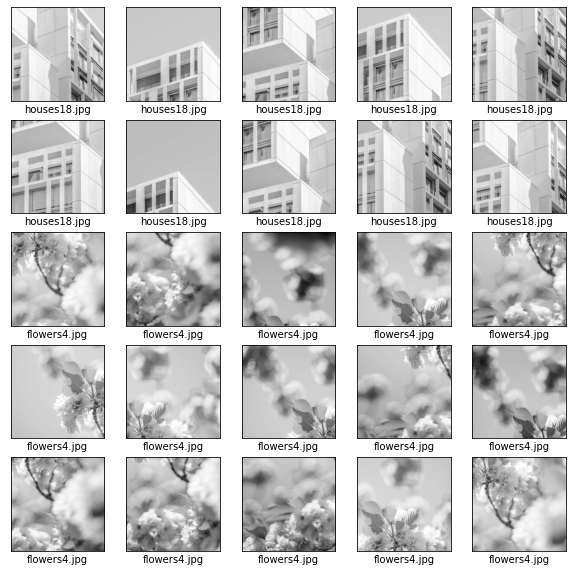

In [0]:
plt.figure(figsize=(10,10))
number_of_visualizations=25
start_index=50
for i in range(start_index, start_index+number_of_visualizations):
    src_image = src_patches[i,:,:]
    src_image = np.squeeze(src_image)
    plt.subplot(5,5,i+1-start_index)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(src_image,cmap='gray')
    plt.xlabel(fnames[i])
plt.show()

Add **Gaussian** **noise** for generating the **input**

In [0]:
noisy_src_patches=[]
noisy_src_patches = src_patches + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=src_patches.shape)
noisy_src_patches = np.clip(noisy_src_patches, 0., 1.)
print(noisy_src_patches.shape )

(2000, 256, 256, 1)


Plot noisy patches

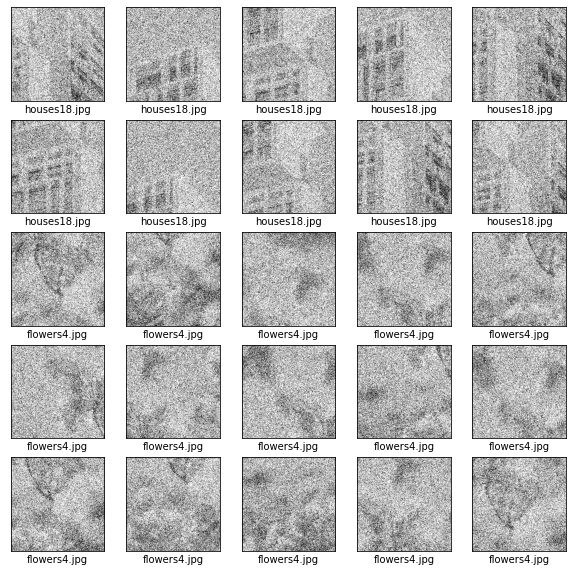

In [0]:
plt.figure(figsize=(10,10))
number_of_visualizations=25
for i in range(start_index, start_index+number_of_visualizations):
    noisy_src_image = noisy_src_patches[i,:,:]
    noisy_src_image = np.squeeze(noisy_src_image)
    plt.subplot(5,5,i+1-start_index)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(noisy_src_image, cmap='gray')
    plt.xlabel(fnames[i])
plt.show()

# Split into training and testing Datasets

In [0]:
# Execute to select randomly train and test
#X_train, X_test, y_train, y_test = train_test_split(noisy_src_patches, src_patches, test_size=0.2, random_state=5) 

In [0]:
split_patches= int(training_portion*(src_patches.shape[0]))
print('Number of train patches: ', split_patches)
print('Number of test patches: ', len(src_patches)-split_patches)


original_train_patches=src_patches[:split_patches, :, :, :]
#print('Original train patches: ', original_train_patches.shape)
noisy_train_patches= noisy_src_patches[:split_patches, :, :, :]
#print('Noisy train patches: ', noisy_train_patches.shape)

original_test_patches=src_patches[split_patches:, :, :, :]
#print('Original test patches: ', original_test_patches.shape)
noisy_test_patches= noisy_src_patches[split_patches:, :, :, :]
#print('Noisy test patches: ',noisy_test_patches.shape)

#Split filenames
train_fnames=fnames[:split_patches]
test_fnames=fnames[split_patches:]

Number of train patches:  1600
Number of test patches:  400


# Defining a Sequential Model using Convolutional Neural Network (CNN)

In [0]:
def create_model():
   cnn_model = Sequential([
## Encoder

    Conv2D(32, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal',input_shape=(img_width, img_height,1)),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), strides=(1,1),padding='same',  kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation("relu"),
## Decoder
    Conv2D(128, (3,3),strides=(1,1), padding='same',  kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation("relu"),
    UpSampling2D((2,2)),

    Conv2D(64, (3,3),strides=(1,1), padding='same',  kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation("relu"),
    UpSampling2D((2,2)),

    
    Conv2D(1, (3,3),strides=(1,1), padding='same', activation='sigmoid')
    ])
   return cnn_model

1. Stride: We set stides to (1,1), i.e.,amount by which the filter shifts

2. Padding :To avoid shrinking of  height/width as we move deeper into the layers, we set this parameter to "same" and preserve image dimensions.

3. Activation: "relu" because it is sparsely activated and  avoids vanishing gradient problem.

4. Kernel_initializer: To  speed up the convergence of gradient descent and to lower training (and generalization) error we choose kernel_initializer to he_normal nitializes ( according to a paper by He et al., 2015). 

5. Batch Normalization: To increase the stability of a neural network ( batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation)

6. Maxpooling: We use pooling layer to reduce computation cost, as well as to make feature detectors more invariant to its position in the input.

7. Upsampling: To scale up the image.


Display the architecture of our model

In [0]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0

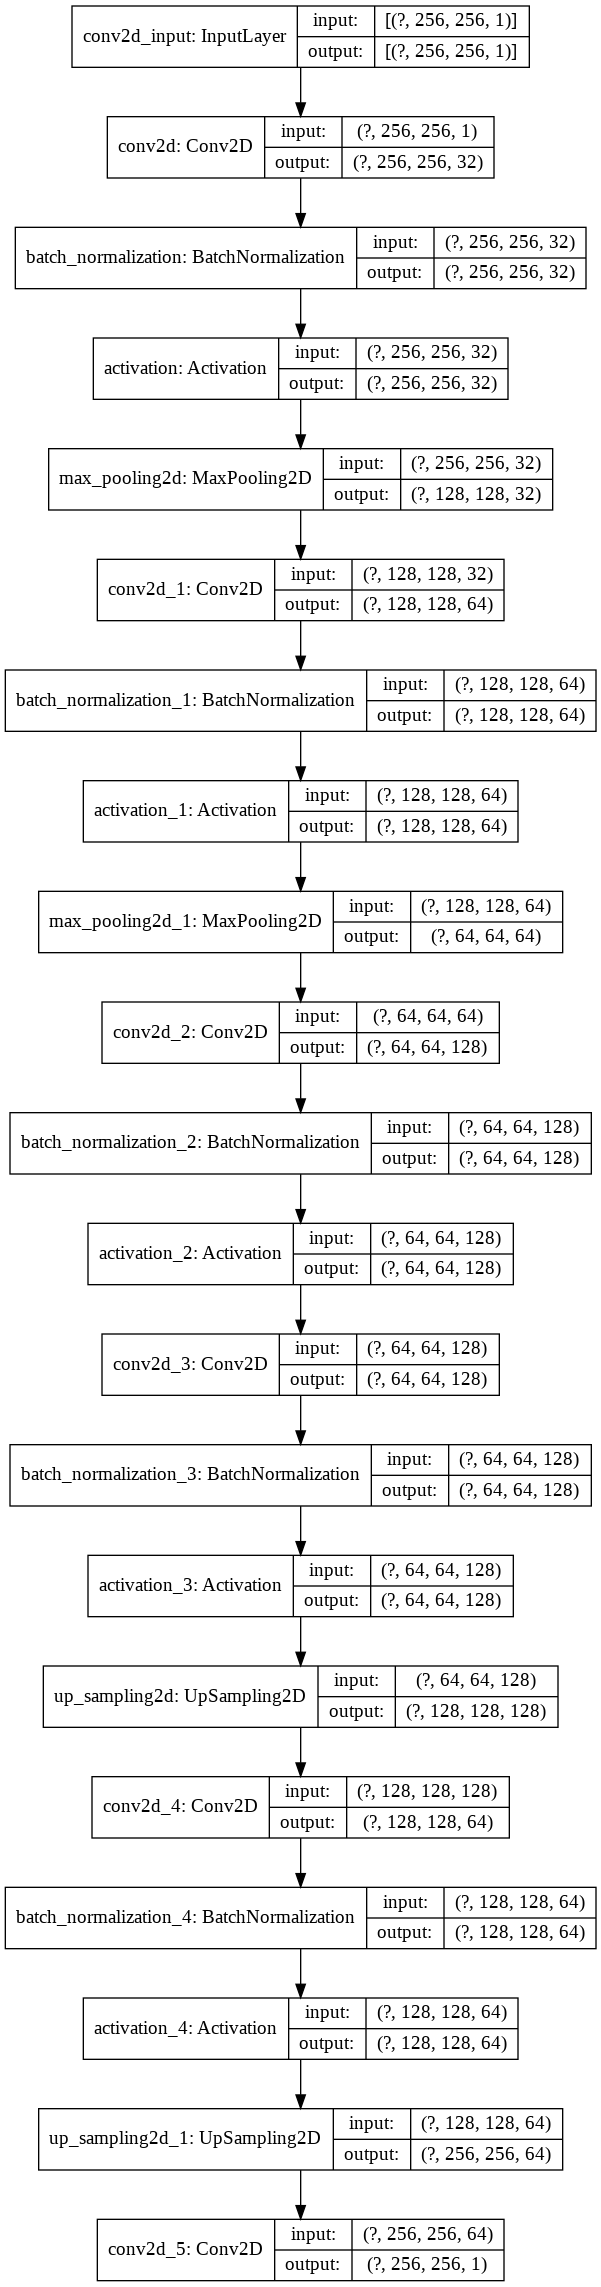

In [0]:
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)  #(For debugging)

As can be seen from Input layer, we are providing a patch of (256,256,1) and obatining an output image of same dimensions as input.

### Tuning the hyper-parameters

 We do some basic hyper parameter tuning to pick a good learning rate for the gradient descent that will help to improve our model.

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-6)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(noisy_train_patches,
    original_train_patches,
    epochs=num_epochs, validation_split=0.2,
    batch_size=batch_size,
    callbacks=[lr_schedule], verbose=1)

Text(0.5, 0, 'Learning Rate')

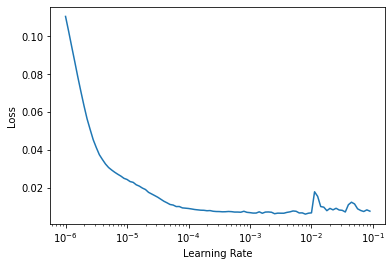

In [0]:
lrs = 1e-6 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
#plt.axis([1e-5,.9, 0, .5])
plt.ylabel('Loss')
plt.xlabel('Learning Rate')


We can  inspect the lower part of the curve before it gets unstable.
We can choose the rate from 1e-3 to 1e-2. We will set the learning rate to be 1e-3 and will compile and train our model in the next steps.


#### Creating checkpoints, compiling and training the model

We use Adam as it one of the most effective optimization algorithms because it combines RMSProp as well as Momentum (required to reduce oscillations in the  path taken by mini-batch gradient descent  towards convergence ).

In [0]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/tmp/training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights 
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))



optimizer = tf.keras.optimizers.Adam(lr=2e-4)
model.compile(loss="mse", optimizer=optimizer)


# Train the model with the new callback
history = model.fit(noisy_train_patches_seq,
    original_train_patches_seq,
     validation_split=0.2,
     batch_size= batch_size,
    epochs=num_epochs,  callbacks=[cp_callback],verbose=1)

## Evaluate the model

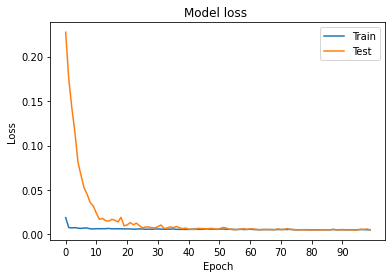

Train Loss: 0.005, Test Loss: 0.006


In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.axis([0,100, 0, 0.09])
plt.xticks(np.arange(0, num_epochs, 10))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

train_loss = model.evaluate(noisy_train_patches,  original_train_patches,verbose=0)
test_loss = model.evaluate(noisy_test_patches,  original_test_patches,verbose=0)
print('Train Loss: %.2f, Test Loss: %.3f' % (train_loss, test_loss))

Our training and testing loss seems pretty good. Our model is not overfitting. By increasing the training data-set, the varaiance can be reduced further.

Plotting Denoised Test Images

(400, 256, 256, 1)


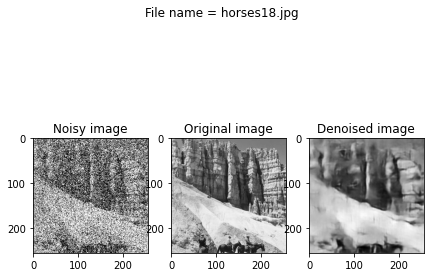

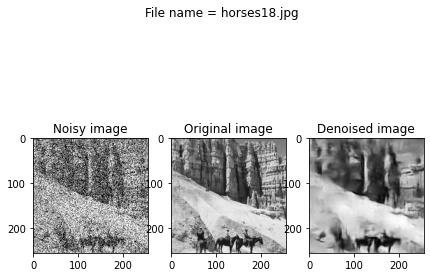

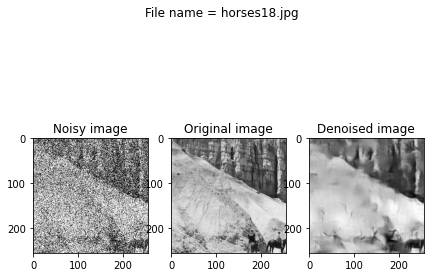

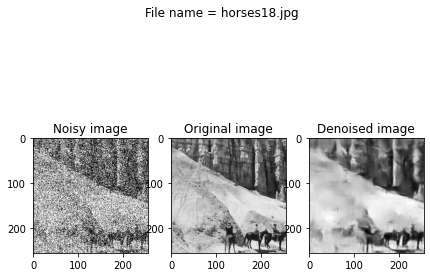

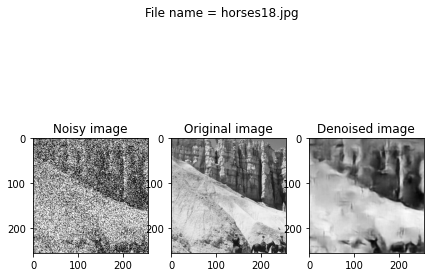

In [0]:
denoised_test_patches = model.predict(noisy_test_patches)
print(denoised_test_patches.shape)
start_index=20

# Plot denoised train images
number_of_visualizations=5
for i in range(start_index, number_of_visualizations+start_index):
  # Get the sample and the reconstruction
  noisy_image = noisy_test_patches[i,:,:]
  noisy_test_image = np.squeeze(noisy_image)

  original_image  = original_test_patches[i,:,:]
  original_test_image = np.squeeze(original_image)

  denoised_image = denoised_test_patches[i,:,:]
  denoised_test_image = np.squeeze(denoised_image)

  input_class = test_fnames[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(7, 5.5)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_test_image,cmap='gray')
  axes[0].set_title('Noisy image')
  axes[1].imshow(original_test_image,cmap='gray')
  axes[1].set_title('Original image')
  axes[2].imshow(denoised_test_image,cmap='gray')
  axes[2].set_title('Denoised image')
  fig.suptitle(f'File name = {input_class}')
  plt.show()

We are not using a very deep layered-network, so to detect more complex textures is not that trivial. Furthermore, our training set is small, we can use Transfer Learning and can take advantage of  using Pre-trained CNNs such as  Xception, VGG16, VGG19, but for the purpose of Task we are keeping the model simple and not using any Transfer Learning.